# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';', error_bad_lines=False)

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';', error_bad_lines=False)

In [3]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [4]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Azdias Database has {} entries with {} features.'.format(azdias.shape[0], azdias.shape[1]))
print('Feature Info has {} attribute details in {} columns.'.format(feat_info.shape[0], feat_info.shape[1]))

Azdias Database has 891221 entries with 85 features.
Feature Info has 85 attribute details in 4 columns.


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,GEBAEUDETYP_RASTER,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
for col in ['attribute', 'information_level', 'type', 'missing_or_unknown']:
    print('In Feature Info, Column {} has {} unique values'.format(col, len(np.unique(feat_info[col]))))

In Feature Info, Column attribute has 85 unique values
In Feature Info, Column information_level has 9 unique values
In Feature Info, Column type has 5 unique values
In Feature Info, Column missing_or_unknown has 9 unique values


In [9]:
#Print all unique values
for col in ['information_level', 'type', 'missing_or_unknown']:
    print('Unique values in Feature Info, column *{}*: \n\t{}'.format(col, (', ').join(np.unique(feat_info[col]).tolist())))

Unique values in Feature Info, column *information_level*: 
	building, community, household, macrocell_plz8, microcell_rr3, microcell_rr4, person, postcode, region_rr1
Unique values in Feature Info, column *type*: 
	categorical, interval, mixed, numeric, ordinal
Unique values in Feature Info, column *missing_or_unknown*: 
	[-1,0,9], [-1,0], [-1,9], [-1,XX], [-1,X], [-1], [0], [XX], []


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Naturally Missing Data:
nat_nulls = azdias.isnull().sum().tolist()
columns = azdias.columns.values.tolist()
# type(nat_null)

In [11]:
# cols_w_nulls = [tup for idx, tup in enumerate(zip(columns, nat_nulls)) if tup[1] > 0]
# cols_w_nulls
cells_w_nulls = np.sum(nat_nulls)
print('Cells with no data naturally: {}'.format(cells_w_nulls))
print('Therefore {0:.3f}% for data has no data naturally!'.format(cells_w_nulls*100/(azdias.shape[0]*azdias.shape[1])))

Cells with no data naturally: 4896838
Therefore 6.464% for data has no data naturally!


In [12]:
# azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';', error_bad_lines=False)
# azdias.head(10)

In [14]:
# Identify missing or unknown data values and convert them to NaNs.
for idx in range(feat_info.shape[0]):
    
    # if idx==1:
        # break
    
    # Find missing or unknown labels wrt the attributes
    attr = feat_info['attribute'][idx]
    miss_unk_labs = feat_info['missing_or_unknown'][idx].replace(' ','')[1:-1].split(',')
    print('For attribute: {}, Missing or Unknown Labels: {}'.format(attr, ', '.join(miss_unk_labs)))
    
    if not miss_unk_labs:
        print('List for Missing or Unknown Labels is empty. Continuing!')
        continue
    
    needs_rep = 0
    print(azdias[attr].value_counts())
    for ele in miss_unk_labs:
        if ele.startswith('-') and ele[1:].isdigit():
            if(azdias[attr].dtype == 'int64'):
                print('Encountered an *Integer* Negative Number: {}'.format(ele))
                needs_rep += azdias[attr].astype(str).str.count('^'+ele, re.M).sum()
                azdias[attr].replace(np.int64(ele), np.nan, inplace=True)
            elif (azdias[attr].dtype == 'float64'):
                print('Encountered a *Float* Negative Number: {}'.format(ele))
                needs_rep += azdias[attr].astype(str).str.count('^'+str(np.float64(ele)), re.M).sum()
                azdias[attr].replace(np.float64(ele), np.nan, inplace=True)
        elif ele.isdigit():
            if(azdias[attr].dtype == 'int64'):
                print('Encountered an *Integer* Positive Number: {}'.format(ele))
                needs_rep += azdias[attr].astype(str).str.count('^'+ele, re.M).sum()
                azdias[attr].replace(np.int64(ele), np.nan, inplace=True)
            elif (azdias[attr].dtype == 'float64'):
                print('Encountered a *Float* Positive Number: {}'.format(ele))
                needs_rep += azdias[attr].astype(str).str.count('^'+str(np.float64(ele)), re.M).sum()
                azdias[attr].replace(np.float64(ele), np.nan, inplace=True)
        else:
            print('Encountered a String: {}'.format(ele))
            if ele == '':
                print('Encountered an *Empty* String, continuing!'.format(ele))
                continue
            needs_rep += azdias[attr].astype(str).str.count('^'+ele, re.M).sum()
            azdias[attr].replace(ele, np.nan, inplace=True)
            
    print('Values replaced {}/{}'.format(needs_rep, azdias.shape[0]))

For attribute: AGER_TYP, Missing or Unknown Labels: -1, 0
-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64
Encountered an *Integer* Negative Number: -1
Encountered a *Float* Positive Number: 0
Values replaced 685843/891221
For attribute: ALTERSKATEGORIE_GROB, Missing or Unknown Labels: -1, 0, 9
3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64
Encountered an *Integer* Negative Number: -1
Encountered an *Integer* Positive Number: 0
Encountered an *Integer* Positive Number: 9
Values replaced 2881/891221
For attribute: ANREDE_KZ, Missing or Unknown Labels: -1, 0
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
Encountered an *Integer* Negative Number: -1
Encountered an *Integer* Positive Number: 0
Values replaced 0/891221
For attribute: CJT_GESAMTTYP, Missing or Unknown Labels: 0
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype:

In [15]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [16]:
cells_w_nulls = np.sum(azdias.isnull().sum().tolist())
print('Cells with no data after replacement: {}'.format(cells_w_nulls))
print('Therefore a total of {0:.3f}% for data has no data after replacement!'\
      .format(cells_w_nulls*100/(azdias.shape[0]*azdias.shape[1])))

Cells with no data after replacement: 8373929
Therefore a total of 11.054% for data has no data after replacement!


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data_col = azdias.isnull().sum()

In [18]:
# missing_data_col
missing_data_col.shape

(85,)

In [19]:
# Investigate patterns in the amount of missing data in each column.
missing_data_col.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

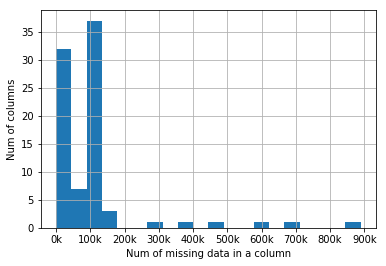

In [20]:
missing_data_col.hist(ax = plt.axes(xlabel = 'Num of missing data in a column', ylabel = 'Num of columns', \
                                xticks = [i for i in range(0, 1000001, 100000)], \
                                xticklabels = [str(int(i/1000))+'k' for i in range(0, 1000001, 100000)]), \
                  bins = 20);

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_cols = missing_data_col[missing_data_col>200000].index
azdias.drop(outlier_cols, axis=1, inplace=True)

In [22]:
print('Azdias Database now has {} entries with {} features.'.format(azdias.shape[0], azdias.shape[1]))
print('6 columns dropped are: {}'.format(', '.join(outlier_cols)))

Azdias Database now has 891221 entries with 79 features.
6 columns dropped are: AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX


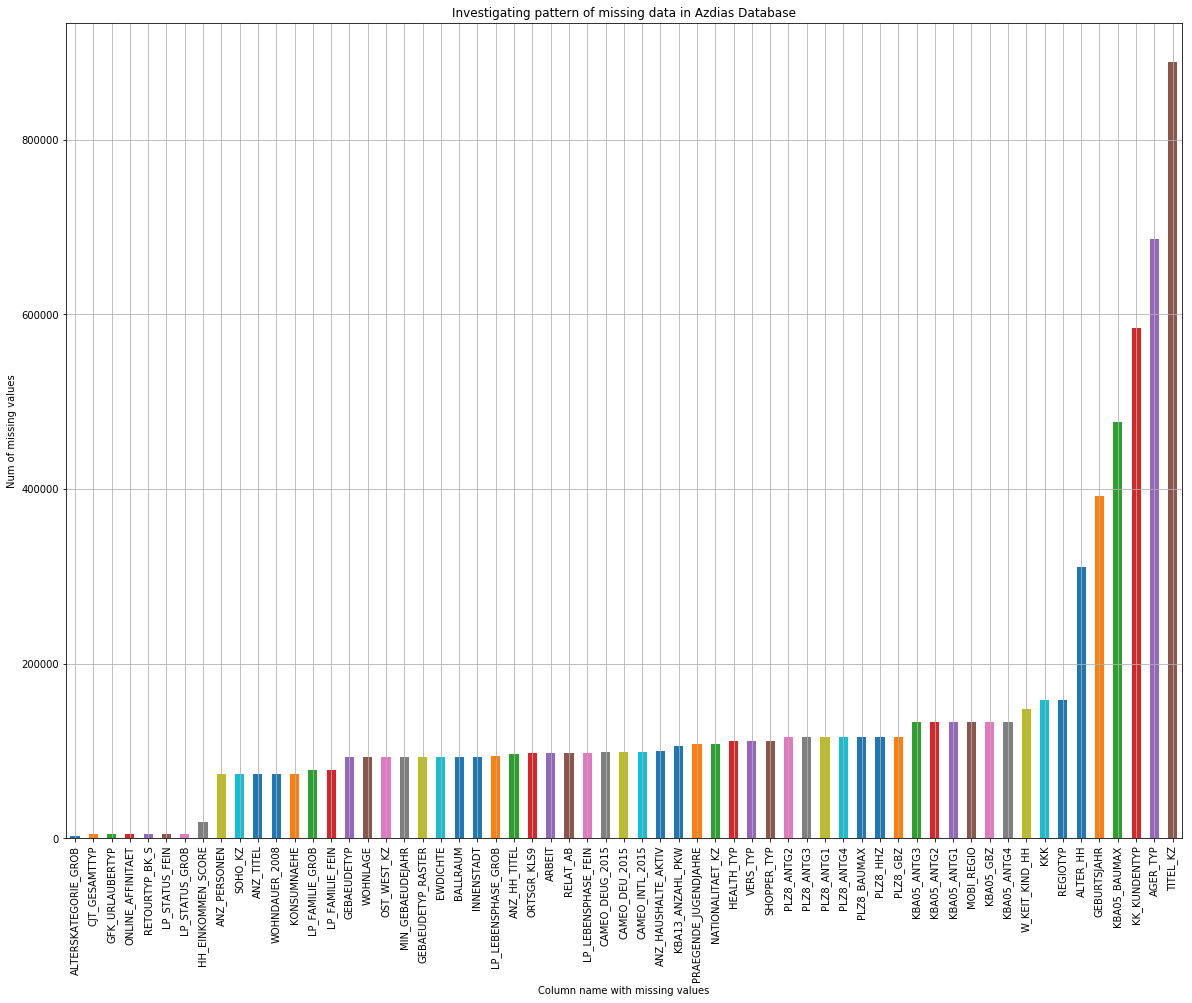

In [23]:
missing_data_col = missing_data_col[missing_data_col>0]
missing_data_col.sort_values(inplace=True)
missing_data_col.plot.bar(figsize=(20,15))
plt.xlabel('Column name with missing values')
plt.ylabel('Num of missing values')
plt.grid(True)
plt.title('Investigating pattern of missing data in Azdias Database')
plt.show()

In [24]:
print('There were a total of {} columns with missing values out of which {} were removed' \
      .format(len(missing_data_col), len(outlier_cols)))
print('Columns removed contains {0:.3f}% of Missing or Unknown Data' \
      .format(np.sum(missing_data_col[missing_data_col>=200000])/np.sum(missing_data_col)*100))

There were a total of 61 columns with missing values out of which 6 were removed
Columns removed contains 39.869% of Missing or Unknown Data


#### Discussion 1.1.2: Assess Missing Data in Each Column

As seen in the plot above, there are 61 columns with one or more missing data out of which 6 columns contains approx 40% of the entire missing or unknown data therefore, these 6 columns can be classified as outliner columns which are likely not contributing much information. Hence, these columns are best to be dropped rather than processed. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [25]:
# How much data is missing in each row of the dataset?
n_md_row = np.sum(azdias.isnull().any(axis=1))
print('Total num of clients having one or more missing data: {}'.format(n_md_row))
print('{0:.3f}% of people have one or more missing data'.format(n_md_row/azdias.shape[0]*100))

Total num of clients having one or more missing data: 268012
30.072% of people have one or more missing data


In [26]:
missing_data_row = azdias.isnull().sum(axis=1)
# missing_client_data

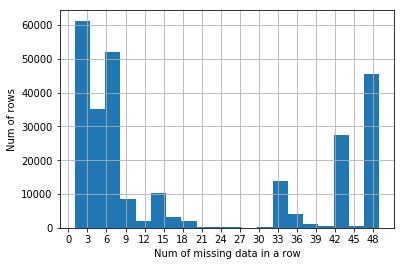

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_data_row[missing_data_row>0].hist(ax = plt.axes(xlabel = 'Num of missing data in a row', ylabel = 'Num of rows', \
                                xticks = [i for i in range(0, 51, 3)]), \
                  bins = 20);

In [28]:
# Dividing at 25
azdias_subsetA = azdias[missing_data_row<=27]
azdias_subsetB = azdias[missing_data_row>27]

In [29]:
print('Num of Rows with <=27 Missing Data: {} .. Percentage: {:.2f}%' \
      .format(azdias_subsetA.shape[0], azdias_subsetA.shape[0]/azdias.shape[0]*100))
print('Num of Rows with >27 Missing Data: {} .. Percentage: {:.2f}%' \
      .format(azdias_subsetB.shape[0], azdias_subsetB.shape[0]/azdias.shape[0]*100))

Num of Rows with <=27 Missing Data: 798044 .. Percentage: 89.55%
Num of Rows with >27 Missing Data: 93177 .. Percentage: 10.45%


In [30]:
missing_data_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

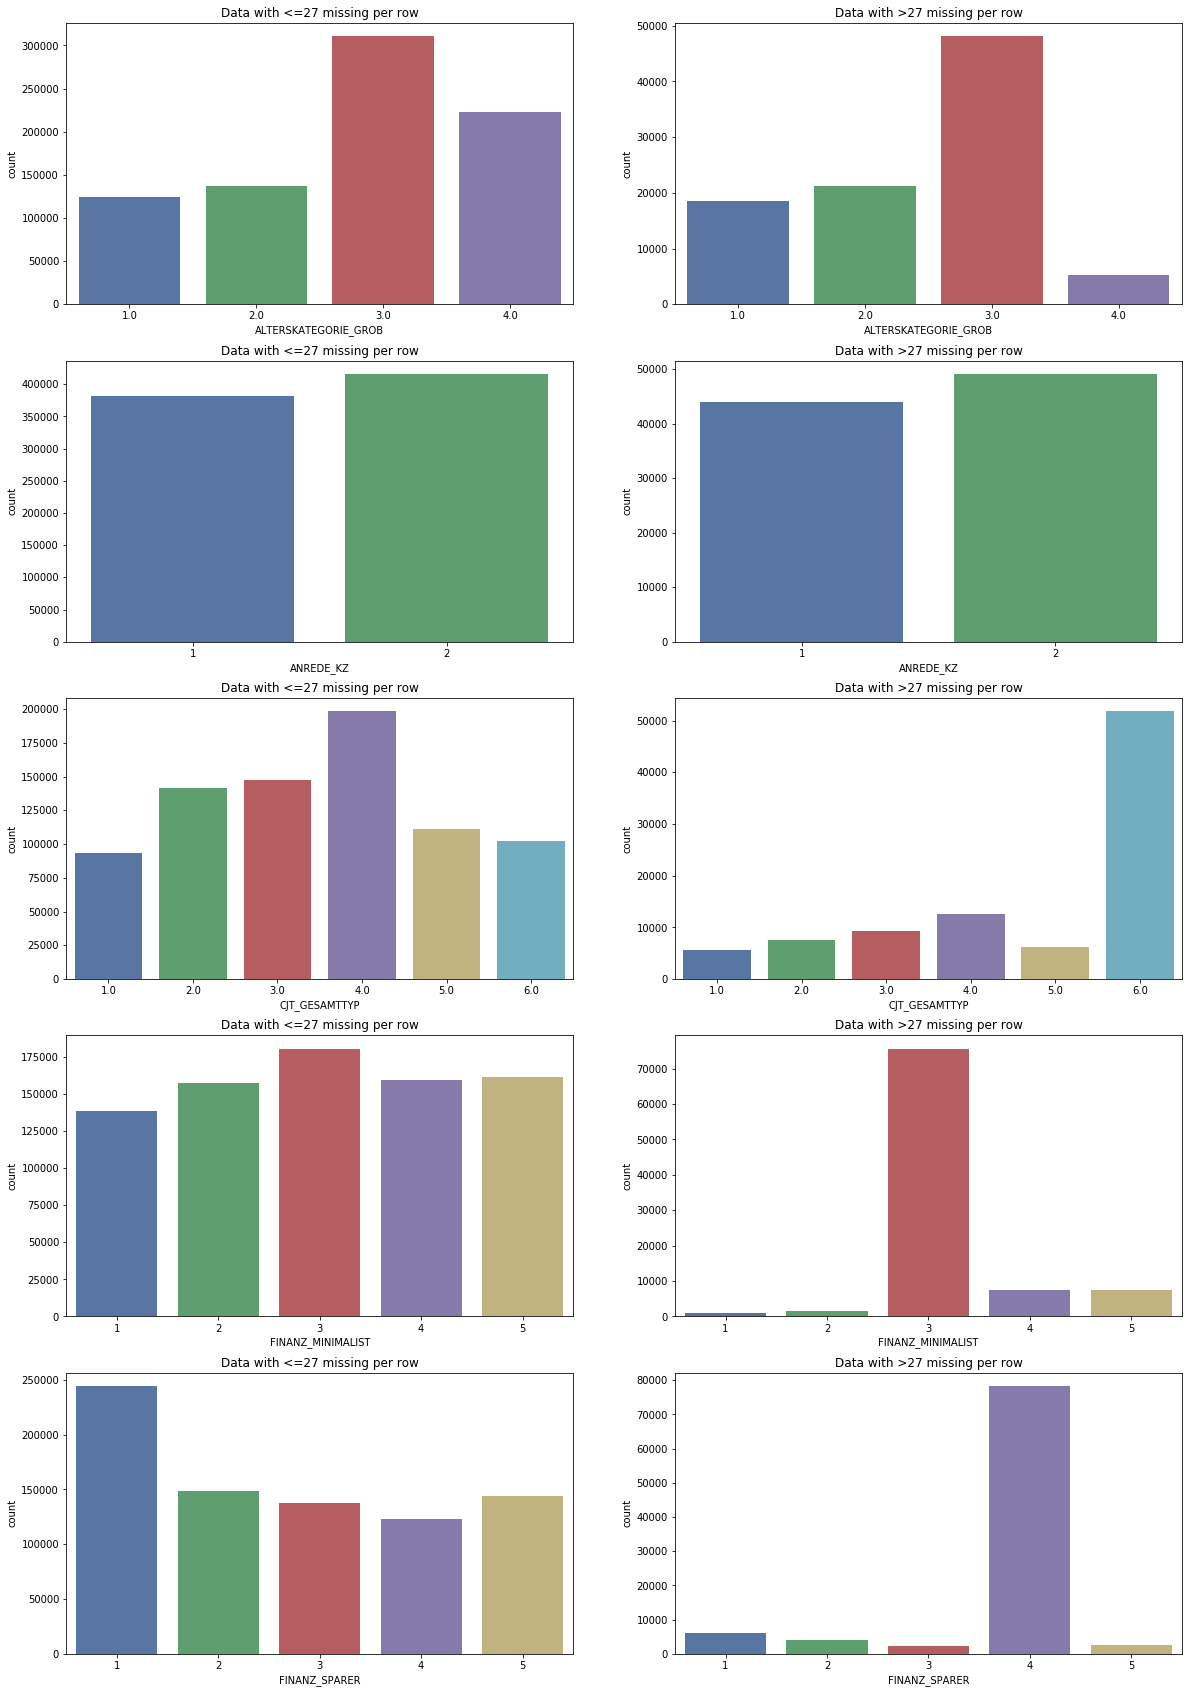

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,30))
n=0
sns.set(style="darkgrid")
for column in azdias.columns[0:5]:
    sns.countplot(azdias_subsetA.loc[:, column], ax=axes[n,0])
    axes[n,0].set_title('Data with <=27 missing per row')
    sns.countplot(azdias_subsetB.loc[:, column], ax=axes[n,1])
    axes[n,1].set_title('Data with >27 missing per row')
    n+=1

#### Discussion 1.1.3: Assess Missing Data in Each Row

Observation:<br>
    ~ Rows with one or more missing data is about 30% of our data set<br>
    ~ Rows with missing more than 34% of features is approx 10%<br>

It is also observed that the rows with fewer missing data is qualitatively different than rows with more missing data. So, it seems best to drop rows with more missing data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# Update Feature Info table with dropped data
for ele in outlier_cols.tolist():
    feat_info.drop(feat_info[feat_info['attribute'] == ele].index, inplace=True)
print('Feature Info now has {} attribute details in {} columns.'.format(feat_info.shape[0], feat_info.shape[1]))

Feature Info now has 79 attribute details in 4 columns.


In [33]:
# How many features are there of each data type?
feat_info.groupby('type').count()
# feat_info.type.value_counts()

,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_cols = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
binary = [x for x in cat_cols if azdias_subsetA[x].nunique()==2]
multilevel = [x for x in cat_cols if azdias_subsetA[x].nunique()>2]
azdias_subsetA[cat_cols].nunique().sort_values()

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [35]:
# Binary
for col in binary:
    print('Col: {} .. Type: {}'.format(col, azdias_subsetA[col].dtype))

Col: ANREDE_KZ .. Type: int64
Col: GREEN_AVANTGARDE .. Type: int64
Col: SOHO_KZ .. Type: float64
Col: VERS_TYP .. Type: float64
Col: OST_WEST_KZ .. Type: object


In [36]:
azdias_subsetA['OST_WEST_KZ'].value_counts()

W    629504
O    168540
Name: OST_WEST_KZ, dtype: int64

In [37]:
azdias_subsetA['OST_WEST_KZ'] = azdias_subsetA['OST_WEST_KZ'].map({'O': 0, 'W': 1})
azdias_subsetA['OST_WEST_KZ'].value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1    629504
0    168540
Name: OST_WEST_KZ, dtype: int64

In [38]:
# Remove cols with more that 5 unique values
remove_cols = []
keep_cols = []
for col in multilevel:
    if azdias_subsetA[col].nunique() > 5:
        remove_cols.append(col)
    else:
        keep_cols.append(col)
        
print('Remove columns:\n{}'.format(azdias_subsetA[remove_cols].nunique().sort_values()))
print('\n\nKeep columns:\n{}'.format(azdias_subsetA[keep_cols].nunique().sort_values()))

Remove columns:
CJT_GESAMTTYP       6
FINANZTYP           6
ZABEOTYP            6
GEBAEUDETYP         7
CAMEO_DEUG_2015     9
LP_STATUS_FEIN     10
LP_FAMILIE_FEIN    11
GFK_URLAUBERTYP    12
CAMEO_DEU_2015     44
dtype: int64


Keep columns:
NATIONALITAET_KZ    3
SHOPPER_TYP         4
LP_FAMILIE_GROB     5
LP_STATUS_GROB      5
dtype: int64


In [39]:
azdias_subsetA.drop(remove_cols, axis=1, inplace=True)
azdias_subsetA.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(798044, 70)

#### Multilevel Categorical Variables
LP_FAMILIE_GROB --> Family Type<br>
LP_STATUS_GROB --> Social status<br>
NATIONALITAET_KZ --> Nationality based on given name analysis<br>
SHOPPER_TYP --> Shopper typology

In [40]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_cat = azdias_subsetA[keep_cols]
azdias_cat.head(5)

,LP_FAMILIE_GROB,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP
1,3.0,1.0,1.0,3.0
2,1.0,2.0,1.0,2.0
3,NaN,4.0,1.0,1.0
4,5.0,2.0,1.0,2.0
5,1.0,2.0,1.0,0.0


In [41]:
azdias_non_cat = azdias_subsetA.drop(keep_cols, axis=1)
azdias_non_cat.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [42]:
for col in keep_cols:
    data = azdias_cat[col][azdias_cat[col].notnull()]
    dummies = pd.get_dummies(data, prefix=col)
    azdias_cat = azdias_cat.join(dummies)
    azdias_cat.drop([col], axis=1, inplace=True)

In [43]:
azdias_cat.head(5)

,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [44]:
azdias_encoded = azdias_non_cat.join(azdias_cat)
azdias_encoded.shape

(798044, 83)

In [45]:
azdias_encoded.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Discussion 1.2.1: Re-Encode Categorical Features

There were a total of 18 Categorical variables out of which 5 were binary. 1 of the 5 binary variables was non-numerical which was manually converted to a (0,1) numerical value, rest were left as is. Out of the 13 multilevel Categorical variables, 9 were removed as they had more than 5 unique values and encoding those variables would have resulted in more features to be processed. One hot encoding was performed on the remaining 4 multilevel Categorical variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
mix_cols = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
print('Mixed Attributes: {}'.format(', '.join(mix_cols)))

Mixed Attributes: LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PRAEGENDE_JUGENDJAHRE, WOHNLAGE, CAMEO_INTL_2015, PLZ8_BAUMAX


#### Mixed Variables
LP_LEBENSPHASE_FEIN --> Life stage, fine scale<br>
LP_LEBENSPHASE_GROB --> Life stage, rough scale<br>
PRAEGENDE_JUGENDJAHRE --> Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)<br>
WOHNLAGE --> Neighborhood quality (or rural flag)<br>
CAMEO_INTL_2015 --> German CAMEO: Wealth / Life Stage Typology, mapped to international code<br>
PLZ8_BAUMAX --> Most common building type within the PLZ8 region<br>

In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
main_vals = [1, 3, 5, 8, 10, 12, 14]
avant_vals = [2, 4, 6, 7, 9, 11, 13, 15]

azdias_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = np.where(azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(main_vals), 1, \
                                                   np.where(azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(avant_vals), 0, np.nan))
azdias_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].value_counts()

1.0    594071
0.0    175222
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64

In [48]:
idx = [i for i in range(1,16)]
year = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    
decade = pd.Series(year, index = idx)
azdias_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(decade)
azdias_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'].value_counts()

90.0    225525
70.0    175195
80.0    151768
60.0    114353
50.0     74295
40.0     28157
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64

In [49]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_encoded.loc[azdias_encoded['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] \
        = azdias_encoded.loc[azdias_encoded['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'] \
                .map(lambda x: int(str(x)[0]))
azdias_encoded.loc[azdias_encoded['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] \
        = azdias_encoded.loc[azdias_encoded['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'] \
                .map(lambda x: int(str(x)[1]))
print(azdias_encoded['CAMEO_INTL_2015_WEALTH'].value_counts())
print(azdias_encoded['CAMEO_INTL_2015_LIFESTAGE'].value_counts())

5.0    223582
2.0    190685
4.0    189960
1.0    119442
3.0     68192
Name: CAMEO_INTL_2015_WEALTH, dtype: int64
1.0    245053
4.0    232776
3.0    119691
5.0    117042
2.0     77299
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: int64


In [50]:
# Removing the rest Mixed Variable
azdias_encoded.drop(mix_cols, axis=1, inplace=True)
azdias_encoded.shape

(798044, 81)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Variables `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` were preserved by breaking them into more meaningful data as guided above. 

For `PRAEGENDE_JUGENDJAHRE` the data was separated into two features: `PRAEGENDE_JUGENDJAHRE_MOVEMENT` and `PRAEGENDE_JUGENDJAHRE_DECADE`. `PRAEGENDE_JUGENDJAHRE_MOVEMENT` describes the movement they are associated with, 1 for mainstream, and 0 for avantgarde. `PRAEGENDE_JUGENDJAHRE_DECADE` contains the decade interval of birth, ranging from 1940 to 1990.

For `CAMEO_INTL_2015` the data was also separated into two features: `CAMEO_INTL_2015_WEALTH` and `CAMEO_INTL_2015_LIFESTAGE`. `CAMEO_INTL_2015_WEALTH` ranges from Poor to Wealthty. `CAMEO_INTL_2015_LIFESTAGE` ranges from Pre-Family Couples and Singles to Elders in Retirement, capturing the 'Life Stage' of the individual.

Besides the above two, rest mixed variables were removed as they had more than 5 unique data except PLZ8_BAUMAX. PLZ8_BAUMAX didn't seem too significant with repect to other variables.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

If there are other re-engineering tasks you need to perform, make sure you take care of them here. (Dealing with missing data will come in step 2.1.)
Do whatever you need to in order to ensure that the dataframe only contains the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2]:
def remove_missing_unknown(df, feat_info):
    for idx in range(feat_info.shape[0]):
    
        # Find missing or unknown labels wrt the attributes
        attr = feat_info['attribute'][idx]
        miss_unk_labs = feat_info['missing_or_unknown'][idx].replace(' ','')[1:-1].split(',')
        # print('For attribute: {}, Missing or Unknown Labels: {}'.format(attr, ', '.join(miss_unk_labs)))
    
        if not miss_unk_labs:
            print('List for Missing or Unknown Labels is empty. Continuing!')
            continue
    
        needs_rep = 0
        # print(df[attr].value_counts())
        for ele in miss_unk_labs:
            if ele.startswith('-') and ele[1:].isdigit():
                if(df[attr].dtype == 'int64'):
                    # print('Encountered an *Integer* Negative Number: {}'.format(ele))
                    needs_rep += df[attr].astype(str).str.count('^'+ele, re.M).sum()
                    df[attr].replace(np.int64(ele), np.nan, inplace=True)
                elif (df[attr].dtype == 'float64'):
                    # print('Encountered a *Float* Negative Number: {}'.format(ele))
                    needs_rep += df[attr].astype(str).str.count('^'+str(np.float64(ele)), re.M).sum()
                    df[attr].replace(np.float64(ele), np.nan, inplace=True)
            elif ele.isdigit():
                if(df[attr].dtype == 'int64'):
                    # print('Encountered an *Integer* Positive Number: {}'.format(ele))
                    needs_rep += df[attr].astype(str).str.count('^'+ele, re.M).sum()
                    df[attr].replace(np.int64(ele), np.nan, inplace=True)
                elif (df[attr].dtype == 'float64'):
                    # print('Encountered a *Float* Positive Number: {}'.format(ele))
                    needs_rep += df[attr].astype(str).str.count('^'+str(np.float64(ele)), re.M).sum()
                    df[attr].replace(np.float64(ele), np.nan, inplace=True)
            else:
                # print('Encountered a String: {}'.format(ele))
                if ele == '':
                    # print('Encountered an *Empty* String, continuing!'.format(ele))
                    continue
                needs_rep += df[attr].astype(str).str.count('^'+ele, re.M).sum()
                df[attr].replace(ele, np.nan, inplace=True)
            
        # print('Values replaced {}/{}'.format(needs_rep, azdias.shape[0]))
    return df

In [3]:
def process_cat_vars(df_subset, cat_cols):
    # binary = [x for x in cat_cols if df_subset[x].nunique()==2]
    # multilevel = [x for x in cat_cols if df_subset[x].nunique()>2]
    
    # binary non-numerical
    df_subset['OST_WEST_KZ'] = df_subset['OST_WEST_KZ'].map({'O': 0, 'W': 1})
    
    # multilevel
    r_cols = ['CJT_GESAMTTYP', 'FINANZTYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 
                   'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']
    k_cols = ['NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_FAMILIE_GROB' , 'LP_STATUS_GROB']
    
    remove_cols = [col for col in r_cols if col in df_subset.columns]
    df_subset.drop(remove_cols, axis=1, inplace=True)
    
    keep_cols = [col for col in k_cols if col in df_subset.columns]
    df_cat = df_subset[keep_cols]
    df_non_cat = df_subset.drop(keep_cols, axis=1)
    
    for col in keep_cols:
        data = df_cat[col][df_cat[col].notnull()]
        dummies = pd.get_dummies(data, prefix=col)
        df_cat = df_cat.join(dummies)
        df_cat.drop([col], axis=1, inplace=True)
        
    df_encoded = df_non_cat.join(df_cat)
    return df_encoded

In [4]:
def process_mixed_vars(df_subset, mix_cols):
    
    # "PRAEGENDE_JUGENDJAHRE": engineer two new variables
    main_vals = [1, 3, 5, 8, 10, 12, 14]
    avant_vals = [2, 4, 6, 7, 9, 11, 13, 15]

    df_subset['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = np.where(df_subset['PRAEGENDE_JUGENDJAHRE'].isin(main_vals), 1, \
                                                   np.where(df_subset['PRAEGENDE_JUGENDJAHRE'].isin(avant_vals), 0, np.nan))
    
    idx = [i for i in range(1,16)]
    year = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    
    decade = pd.Series(year, index = idx)
    df_subset['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_subset['PRAEGENDE_JUGENDJAHRE'].map(decade)
    
    # "CAMEO_INTL_2015": engineer two new variables.
    df_subset.loc[df_subset['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] \
        = df_subset.loc[df_subset['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'] \
                .map(lambda x: int(str(x)[0]))
    df_subset.loc[df_subset['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] \
        = df_subset.loc[df_subset['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'] \
                .map(lambda x: int(str(x)[1]))

    # Removing the rest Mixed Variable
    df_subset.drop(mix_cols, axis=1, inplace=True)
    
    return df_subset

In [5]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # Load in the feature summary file.
    feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';', error_bad_lines=False)
    
    # convert missing value codes into NaNs, ...
    df = remove_missing_unknown(df, feat_info)
    
    # remove selected columns and rows, ...
    # missing_data_col = df.isnull().sum()
    # outlier_cols = missing_data_col[missing_data_col>200000].index
    outlier_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(outlier_cols, axis=1, inplace=True)
    
    missing_data_row = df.isnull().sum(axis=1)
    df_subset = df[missing_data_row<=27]
    
    # removed droped attributes from feat_info
    for ele in outlier_cols:
        feat_info.drop(feat_info[feat_info['attribute'] == ele].index, inplace=True)
    
    # select, re-encode, and engineer column values
    # process categorical vars
    cat_cols = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
    df_subset = process_cat_vars(df_subset, cat_cols)
    
    # process mixed vars
    mix_cols = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
    df_clean = process_mixed_vars(df_subset, mix_cols)
    
    # Return the cleaned dataframe.
    return df_clean
    

In [7]:
df_azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';', error_bad_lines=False)
df_azdias = clean_data(df_azdias)
df_azdias.head(5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,90.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,90.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,NaN,0.0,0.0,0.0,1.0,0.0,1.0,70.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,70.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,50.0,5.0,4.0


In [6]:
def calc_nulls(df):
    cells_w_nulls = np.sum(df.isnull().sum().tolist())
    print('Total num of empty data: {}/{}'.format(cells_w_nulls, df_azdias.shape[0]*df_azdias.shape[1]))
    if cells_w_nulls:
        print('{0:.3f}% of data is empty!'.format(cells_w_nulls*100/(df.shape[0]*df.shape[1])))

In [8]:
calc_nulls(df_azdias)

Total num of empty data: 1192447/64641564
1.845% of data is empty!


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [9]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(strategy='most_frequent')
df_azdias_clean = pd.DataFrame(imputer.fit_transform(df_azdias), columns = df_azdias.columns)
calc_nulls(df_azdias_clean)

Total num of empty data: 0/64641564


In [10]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
df_azdias_clean = pd.DataFrame(scaler.fit_transform(df_azdias_clean), columns = df_azdias_clean.columns)

In [12]:
df_azdias_clean.shape

(798044, 81)

### Discussion 2.1: Apply Feature Scaling

Approx 1.8% data where null which was imputed using Imputer. Further the data was standardized using Standard Scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [68]:
# Apply PCA to the data.
pca = PCA(random_state=15)
df_azdias_pca = pca.fit_transform(df_azdias_clean)

In [65]:
def calc_n_comps(pca, perc):
    req_var = perc/100
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)
    n_components = min(np.where(cumvals>req_var)[0])+1

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1],True)
    ax2 = ax.twinx()
    ax.plot(vals, label='Variance',)
    ax2.plot(cumvals, label='Cumulative Variance', color = 'orange')
    ax.set_title('Explained Variance for {} Principal Component - {}%'.format(n_components, perc))
    ax.axvline(n_components, linestyle='dashed', color='black')
    ax2.axhline(cumvals[n_components], linestyle='dashed', color='black')
    fig.legend(loc=(0.6,0.2))
    
    return n_components

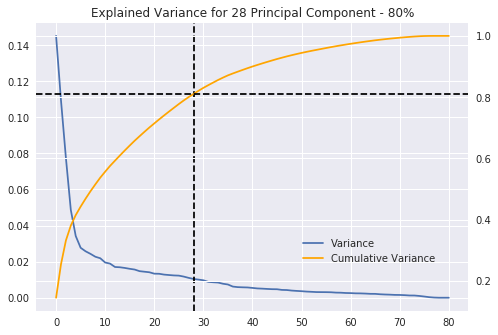

In [69]:
# Investigate the variance accounted for by each principal component.
n_components = calc_n_comps(pca, 80)

In [13]:
# n_components=28
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=n_components, random_state=15)
df_azdias_pca = pca.fit_transform(df_azdias_clean)
print('Total Variance: {}%'.format(pca.explained_variance_ratio_.sum()*100))

Total Variance: 79.99402389968289%


### Discussion 2.2: Perform Dimensionality Reduction

Firstly perform PCA with default number of components to analyze the cummulative sum of explained variance ratio attribute. Then calculate number of components required to achieve desired variance (here 80%).

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [72]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def interpret_pc(df, pca):
    pca_comps = pca.components_
    features = pd.Series(df.columns, range(len(df.columns)))
    
    components = {}
    
    # Identify Feature Variance and Sort in Descending Order
    for i in range(pca_comps.shape[0]):
        components['PC{}'.format(i+1)] = [(features[col_idx], np.round(col_var, 4)) for col_idx, col_var in \
                          sorted(enumerate(pca_comps[i]), key=lambda x: x[1], reverse=True)]
        
    # Create index and column labels
    cmp_idx = ['Feature{}'.format(i) for i in range(1, pca_comps.shape[1]+1)]
    
    df_components = pd.DataFrame(components, index=cmp_idx).transpose()
    
    return df_components

In [73]:
df_components = interpret_pc(df_azdias_clean, pca)
df_components.shape

(28, 81)

In [74]:
df_components.loc['PC1',:]

Feature1                  (LP_STATUS_GROB_1.0, 0.218)
Feature2                         (PLZ8_ANTG3, 0.2117)
Feature3                          (PLZ8_ANTG4, 0.204)
Feature4                 (HH_EINKOMMEN_SCORE, 0.2012)
Feature5             (CAMEO_INTL_2015_WEALTH, 0.1968)
Feature6                        (ORTSGR_KLS9, 0.1839)
Feature7                           (EWDICHTE, 0.1821)
Feature8                   (FINANZ_HAUSBAUER, 0.1614)
Feature9                        (KBA05_ANTG4, 0.1477)
Feature10                        (PLZ8_ANTG2, 0.1448)
Feature11                     (FINANZ_SPARER, 0.1383)
Feature12                       (KBA05_ANTG3, 0.1335)
Feature13                            (ARBEIT, 0.1332)
Feature14               (ANZ_HAUSHALTE_AKTIV, 0.1312)
Feature15                          (RELAT_AB, 0.1261)
Feature16    (PRAEGENDE_JUGENDJAHRE_MOVEMENT, 0.1139)
Feature17                     (SEMIO_PFLICHT, 0.1068)
Feature18                         (SEMIO_REL, 0.1022)
Feature19      (PRAEGENDE_JU

In [75]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df_components.loc['PC2',:]

Feature1             (ALTERSKATEGORIE_GROB, 0.2554)
Feature2                        (SEMIO_ERL, 0.2321)
Feature3                 (FINANZ_VORSORGER, 0.2263)
Feature4                       (SEMIO_LUST, 0.1797)
Feature5                   (RETOURTYP_BK_S, 0.1571)
Feature6                       (SEMIO_KRIT, 0.1199)
Feature7                   (W_KEIT_KIND_HH, 0.1182)
Feature8                       (SEMIO_KAEM, 0.1174)
Feature9                 (FINANZ_HAUSBAUER, 0.1129)
Feature10                        (ANREDE_KZ, 0.097)
Feature11                  (SHOPPER_TYP_3.0, 0.095)
Feature12                         (EWDICHTE, 0.084)
Feature13                      (PLZ8_ANTG3, 0.0833)
Feature14                     (ORTSGR_KLS9, 0.0826)
Feature15                      (PLZ8_ANTG4, 0.0814)
Feature16                       (SEMIO_DOM, 0.0769)
Feature17            (NATIONALITAET_KZ_1.0, 0.0768)
Feature18          (CAMEO_INTL_2015_WEALTH, 0.0663)
Feature19                     (KBA05_ANTG4, 0.0654)
Feature20   

In [76]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df_components.loc['PC3',:]

Feature1                          (SEMIO_VERT, 0.3322)
Feature2                           (SEMIO_SOZ, 0.2554)
Feature3                           (SEMIO_FAM, 0.2408)
Feature4                           (SEMIO_KULT, 0.224)
Feature5                    (FINANZ_MINIMALIST, 0.147)
Feature6                     (SHOPPER_TYP_0.0, 0.1247)
Feature7                      (RETOURTYP_BK_S, 0.1095)
Feature8                    (FINANZ_VORSORGER, 0.1025)
Feature9                      (W_KEIT_KIND_HH, 0.0962)
Feature10               (ALTERSKATEGORIE_GROB, 0.0799)
Feature11                         (SEMIO_LUST, 0.0654)
Feature12                          (SEMIO_REL, 0.0643)
Feature13                         (ORTSGR_KLS9, 0.057)
Feature14                            (EWDICHTE, 0.056)
Feature15                         (PLZ8_ANTG4, 0.0554)
Feature16                         (PLZ8_ANTG3, 0.0545)
Feature17                            (SEMIO_MAT, 0.05)
Feature18                    (SHOPPER_TYP_1.0, 0.0488)
Feature19 

In [77]:
# All Principal Components, weights in descending order column wise
df_components

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature72,Feature73,Feature74,Feature75,Feature76,Feature77,Feature78,Feature79,Feature80,Feature81
PC1,"(LP_STATUS_GROB_1.0, 0.218)","(PLZ8_ANTG3, 0.2117)","(PLZ8_ANTG4, 0.204)","(HH_EINKOMMEN_SCORE, 0.2012)","(CAMEO_INTL_2015_WEALTH, 0.1968)","(ORTSGR_KLS9, 0.1839)","(EWDICHTE, 0.1821)","(FINANZ_HAUSBAUER, 0.1614)","(KBA05_ANTG4, 0.1477)","(PLZ8_ANTG2, 0.1448)",...,"(LP_STATUS_GROB_4.0, -0.1233)","(LP_STATUS_GROB_5.0, -0.124)","(INNENSTADT, -0.1529)","(PLZ8_GBZ, -0.1554)","(KONSUMNAEHE, -0.1574)","(KBA05_ANTG1, -0.2061)","(KBA05_GBZ, -0.2079)","(PLZ8_ANTG1, -0.2119)","(MOBI_REGIO, -0.2154)","(FINANZ_MINIMALIST, -0.2162)"
PC2,"(ALTERSKATEGORIE_GROB, 0.2554)","(SEMIO_ERL, 0.2321)","(FINANZ_VORSORGER, 0.2263)","(SEMIO_LUST, 0.1797)","(RETOURTYP_BK_S, 0.1571)","(SEMIO_KRIT, 0.1199)","(W_KEIT_KIND_HH, 0.1182)","(SEMIO_KAEM, 0.1174)","(FINANZ_HAUSBAUER, 0.1129)","(ANREDE_KZ, 0.097)",...,"(SEMIO_RAT, -0.1641)","(SEMIO_FAM, -0.1879)","(FINANZ_ANLEGER, -0.1978)","(FINANZ_UNAUFFAELLIGER, -0.2203)","(SEMIO_KULT, -0.2224)","(SEMIO_PFLICHT, -0.2242)","(SEMIO_TRADV, -0.2263)","(FINANZ_SPARER, -0.2308)","(PRAEGENDE_JUGENDJAHRE_DECADE, -0.236)","(SEMIO_REL, -0.2548)"
PC3,"(SEMIO_VERT, 0.3322)","(SEMIO_SOZ, 0.2554)","(SEMIO_FAM, 0.2408)","(SEMIO_KULT, 0.224)","(FINANZ_MINIMALIST, 0.147)","(SHOPPER_TYP_0.0, 0.1247)","(RETOURTYP_BK_S, 0.1095)","(FINANZ_VORSORGER, 0.1025)","(W_KEIT_KIND_HH, 0.0962)","(ALTERSKATEGORIE_GROB, 0.0799)",...,"(SHOPPER_TYP_2.0, -0.1025)","(FINANZ_SPARER, -0.1067)","(PRAEGENDE_JUGENDJAHRE_DECADE, -0.1132)","(SEMIO_ERL, -0.1703)","(FINANZ_ANLEGER, -0.1904)","(SEMIO_RAT, -0.2143)","(SEMIO_KRIT, -0.2658)","(SEMIO_DOM, -0.3051)","(SEMIO_KAEM, -0.3248)","(ANREDE_KZ, -0.3556)"
PC4,"(GREEN_AVANTGARDE, 0.3724)","(LP_STATUS_GROB_5.0, 0.2926)","(EWDICHTE, 0.2433)","(ORTSGR_KLS9, 0.2372)","(ANZ_PERSONEN, 0.1628)","(ONLINE_AFFINITAET, 0.1485)","(LP_FAMILIE_GROB_5.0, 0.1289)","(PLZ8_ANTG3, 0.1105)","(RELAT_AB, 0.1041)","(SEMIO_DOM, 0.1031)",...,"(KONSUMNAEHE, -0.1347)","(W_KEIT_KIND_HH, -0.1354)","(LP_FAMILIE_GROB_1.0, -0.1617)","(REGIOTYP, -0.1644)","(LP_STATUS_GROB_4.0, -0.1865)","(HH_EINKOMMEN_SCORE, -0.2016)","(INNENSTADT, -0.2028)","(BALLRAUM, -0.2078)","(KKK, -0.2084)","(PRAEGENDE_JUGENDJAHRE_MOVEMENT, -0.3724)"
PC5,"(ANZ_PERSONEN, 0.3679)","(LP_FAMILIE_GROB_5.0, 0.3099)","(KKK, 0.2302)","(REGIOTYP, 0.1859)","(ONLINE_AFFINITAET, 0.1814)","(LP_FAMILIE_GROB_4.0, 0.1242)","(ARBEIT, 0.1153)","(LP_STATUS_GROB_4.0, 0.1147)","(PRAEGENDE_JUGENDJAHRE_MOVEMENT, 0.1078)","(WOHNDAUER_2008, 0.0989)",...,"(SHOPPER_TYP_1.0, -0.0832)","(GREEN_AVANTGARDE, -0.1078)","(KBA05_ANTG2, -0.1253)","(LP_STATUS_GROB_2.0, -0.128)","(OST_WEST_KZ, -0.1523)","(PLZ8_HHZ, -0.2302)","(KBA13_ANZAHL_PKW, -0.235)","(PLZ8_GBZ, -0.236)","(W_KEIT_KIND_HH, -0.3013)","(LP_FAMILIE_GROB_1.0, -0.3822)"
PC6,"(KBA13_ANZAHL_PKW, 0.463)","(PLZ8_HHZ, 0.4376)","(PLZ8_GBZ, 0.3203)","(ANZ_PERSONEN, 0.2161)","(LP_FAMILIE_GROB_5.0, 0.1831)","(OST_WEST_KZ, 0.1514)","(KBA05_ANTG4, 0.1217)","(ANZ_HAUSHALTE_AKTIV, 0.1115)","(PRAEGENDE_JUGENDJAHRE_MOVEMENT, 0.0916)","(NATIONALITAET_KZ_2.0, 0.0855)",...,"(ORTSGR_KLS9, -0.091)","(GREEN_AVANTGARDE, -0.0916)","(LP_STATUS_GROB_5.0, -0.0933)","(KBA05_ANTG1, -0.13)","(MOBI_REGIO, -0.15)","(W_KEIT_KIND_HH, -0.1611)","(RELAT_AB, -0.162)","(KBA05_GBZ, -0.1634)","(ARBEIT, -0.2166)","(LP_FAMILIE_GROB_1.0, -0.2168)"
PC7,"(KBA05_ANTG4, 0.3447)","(ANZ_HAUSHALTE_AKTIV, 0.3001)","(ANZ_HH_TITEL, 0.2218)","(MIN_GEBAEUDEJAHR, 0.2108)","(SHOPPER_TYP_3.0, 0.1612)","(NATIONALITAET_KZ_1.0, 0.095)","(SHOPPER_TYP_1.0, 0.0765)","(LP_FAMILIE_GROB_1.0, 0.0754)","(ANZ_TITEL, 0.0698)","(PLZ8_ANTG4, 0.0629)",...,"(OST_WEST_KZ, -0.1518)","(MOBI_REGIO, -0.154)","(REGIOTYP, -0.1574)","(SHOPPER_TYP_2.0, -0.1623)","(GEBAEUDETYP_RASTER, -0.1635)","(RELAT_AB, -0.1699)","(KKK, -0.1857)","(KBA05_ANTG3, -0.1952)","(PLZ8_ANTG2, -0.2281)","(KBA05_ANTG2, -0.381)"
PC8,"(FINANZ_HAUSBAUE

### Discussion 2.3: Interpret Principal Components

<b>Principal Component 1:</b><br>
This component focuses on the `Lower Income Group` of people who usually reside in 6+ family homes and whose financial mindset is to be prepared for the worst. It weighs info relating to their estimated household income and their living - residence type, density, size of community. It correctly negates features relating to people living in 1-2 family homes.
    
<b>Principal Component 2:</b><br>
This component seems to be targeting the `Youth`. It weighs on thier age, whether they have children and there personality type - event-oriented, sensual-minded or critical-minded. It also accounts for their mindset to be financially prepared and what kind of a shopper they are. It correctly negates personality traits like - dutiful, tradional-minded, religious and financial mindset of money-saver which is more prominent in old aged people.
    
<b>Principal Component 3:</b><br>
This component is a little vague however, it can be inferred that this focuses on `Housewives` as they are usually flexible, dreamful, social-minded, family-minded and/or cultural-minded. All the more, they are usually content with what is provided to them and have low interest in investing. It correctly negates out less likely harsh personality traits such as critical-minded, dominant-minded, combative attitude as well as gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [15]:
def kmeans_scree_plot(centers, scores):
    plt.plot(centers, scores, linestyle='--', marker='o', color='b')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.title('SSE vs. K')
    

In [81]:
# Over a number of different cluster counts...
kmeans_centers = []
kmeans_scores = []

for i in range(2,50,1):
    kmeans_centers.append(i)
    # run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(i, random_state=15)
    kmeans.fit(df_azdias_pca)
    
    # compute the average within-cluster distances.
    kmeans_scores.append(kmeans.score(df_azdias_pca))
    print('For {} clusters, Score is {}'.format(i,kmeans.score(df_azdias_pca)))
    

For 2 clusters, Score is -45944084.43241326
For 3 clusters, Score is -42163165.04976492
For 4 clusters, Score is -39606245.010635085
For 5 clusters, Score is -38205584.70737121
For 6 clusters, Score is -37783731.87290129
For 7 clusters, Score is -35163377.66404629
For 8 clusters, Score is -34453825.914159805
For 9 clusters, Score is -34050544.15248984
For 10 clusters, Score is -33628374.46158176
For 11 clusters, Score is -33771812.355168685
For 12 clusters, Score is -32512048.556188144
For 13 clusters, Score is -32234513.51158244
For 14 clusters, Score is -32517056.274841975
For 15 clusters, Score is -32122009.72314991
For 16 clusters, Score is -31955750.283829384
For 17 clusters, Score is -31334924.020727076
For 18 clusters, Score is -31138606.20287509
For 19 clusters, Score is -30876394.752691634
For 20 clusters, Score is -30386012.794611353
For 21 clusters, Score is -29169348.316882588
For 22 clusters, Score is -28725686.27407428
For 23 clusters, Score is -27953672.55019218
For 24 c

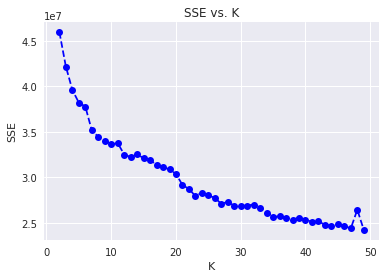

In [82]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
kmeans_scree_plot(kmeans_centers, np.absolute(kmeans_scores))

In [83]:
# Over a number of different cluster counts...
kmeans_centers = []
kmeans_scores = []

for i in range(2,36,3):
    kmeans_centers.append(i)
    # run k-means clustering on the data and...
    kmeans = KMeans(i, random_state=15)
    kmeans.fit(df_azdias_pca)
    
    # compute the average within-cluster distances.
    kmeans_scores.append(kmeans.score(df_azdias_pca))
    print('For {} clusters, Score is {}'.format(i,kmeans.score(df_azdias_pca)))

For 2 clusters, Score is -44623673.401960745
For 5 clusters, Score is -37406731.54088737
For 8 clusters, Score is -33890935.732233405
For 11 clusters, Score is -32095441.66980276
For 14 clusters, Score is -30676136.572894458
For 17 clusters, Score is -29243705.736418005
For 20 clusters, Score is -28730605.823076617
For 23 clusters, Score is -27802848.992222115
For 26 clusters, Score is -27028640.467167668
For 29 clusters, Score is -26275345.951731417
For 32 clusters, Score is -25876937.228459883
For 35 clusters, Score is -25514884.72468694


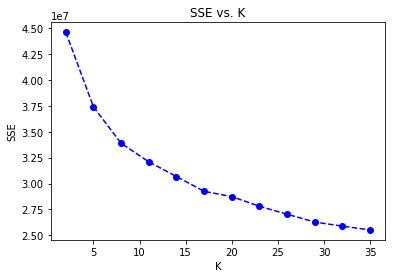

In [16]:
# kmeans_centers = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35]
# kmeans_scores = [-44623673.401960745, -37406731.54088737, -33890935.732233405, -32095441.66980276, -30676136.572894458, -29243705.736418005, -28730605.823076617, -27802848.992222115, -27028640.467167668, -26275345.951731417, -25876937.228459883, -25514884.72468694]
kmeans_scree_plot(kmeans_centers, np.absolute(kmeans_scores))

In [17]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(23, random_state=15)
clusters_pop = kmeans.fit_predict(df_azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

As this is a huge data set therefore MiniBatchKmeans was used to approximate apt number of clusters. Then KMeans was used on a fewer numbers of clusters. It is observed with the MiniBatchKmeans scree plot that the scores are pretty closely placed after 23 clusters. Also, flattening of curve can be seen in the KMeans scree plot at 23 clusters. Therefore considering 23 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [18]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';', error_bad_lines=False)

In [19]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers)
customers = pd.DataFrame(imputer.fit_transform(customers), columns = customers.columns)
customers = pd.DataFrame(scaler.fit_transform(customers), columns = customers.columns)
calc_nulls(customers)
print(customers.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Total num of empty data: 0/64641564
(141721, 81)


In [20]:
customers.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,0.701605,-0.702942,0.723172,-0.517026,0.516281,-0.600725,0.136964,-0.553071,1.006975,-1.256237,...,-0.819424,-0.397484,-0.401343,-0.353720,-0.542780,1.321725,-0.988585,-0.655031,-1.138271,-0.277245
1,0.701605,1.422592,0.723172,-0.517026,0.516281,-0.600725,2.180628,0.965853,1.006975,0.048547,...,-0.819424,-0.397484,-0.401343,-0.353720,-0.542780,1.321725,-0.988585,-0.655031,0.288019,0.470153
2,0.701605,-0.702942,0.723172,-0.517026,0.516281,0.396713,-0.884868,-0.553071,-0.993074,0.048547,...,-0.819424,-0.397484,-0.401343,-0.353720,1.842366,-0.756587,1.011547,-1.399507,-0.425126,0.470153
3,-0.668418,-0.702942,-1.241342,-0.517026,-0.665390,2.391589,3.202460,-0.553071,-0.993074,1.353331,...,1.220370,2.515827,-0.401343,-0.353720,-0.542780,-0.756587,1.011547,0.833921,1.001163,-1.772041
4,-0.668418,-0.702942,0.723172,-0.517026,0.516281,-0.600725,0.136964,0.206391,1.006975,1.353331,...,-0.819424,-0.397484,-0.401343,2.827092,-0.542780,-0.756587,-0.988585,-0.655031,0.288019,0.470153


In [69]:
# Apply the fitted pca and kmeans on the customer data
cpca = pca.transform(customers)
clusters_cust = kmeans.predict(cpca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

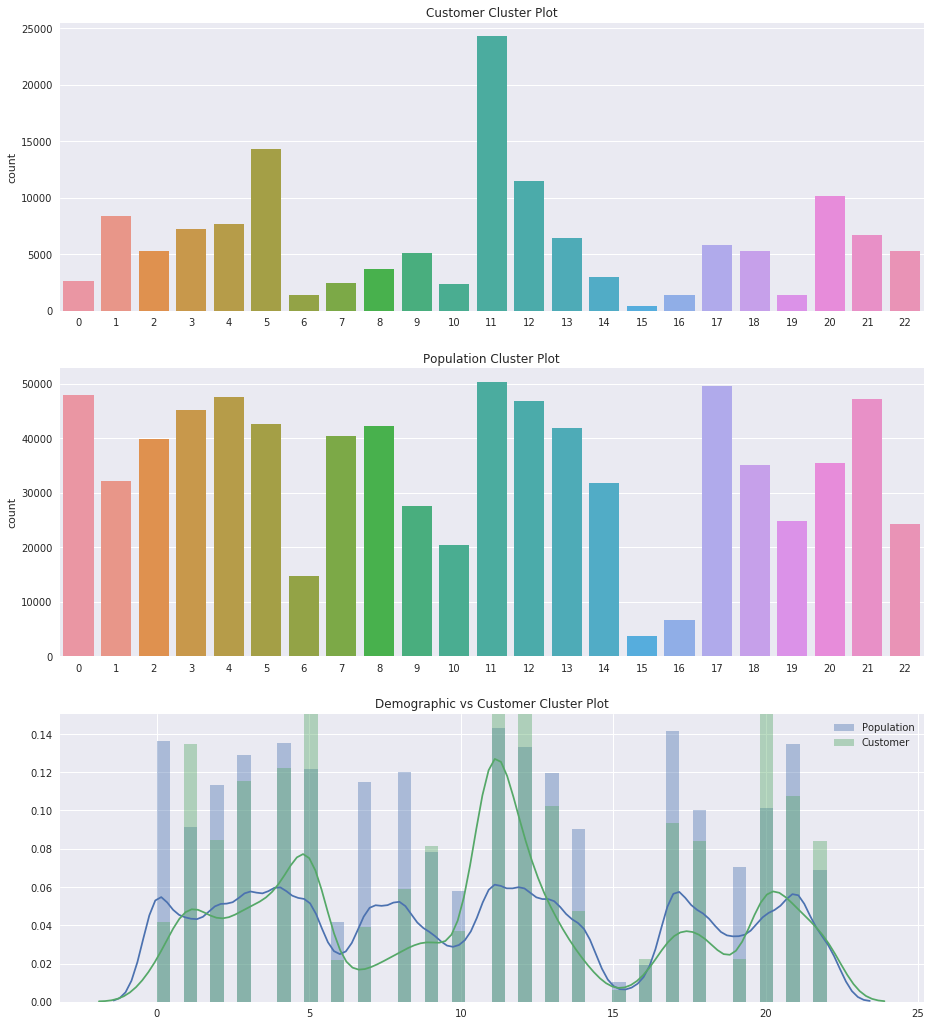

In [70]:
fig = plt.figure()
ax=fig.add_axes([0,0,2,1], title='Demographic vs Customer Cluster Plot')
ax2=fig.add_axes([0,1.2,2,1], title='Population Cluster Plot')
ax3=fig.add_axes([0,2.4,2,1], title='Customer Cluster Plot')
sns.set(style="darkgrid")
sns.distplot(clusters_pop, label='Population',ax=ax)
sns.distplot(clusters_cust, label='Customer', ax=ax)
sns.countplot(clusters_pop, label='Population', ax=ax2)
sns.countplot(clusters_cust, label='Customer', ax=ax3)
ax.legend();

In [46]:
azdias_pred = pd.DataFrame(clusters_pop, columns=['prediction'])
azdias_prop = azdias_pred.reset_index().groupby('prediction').count()/len(clusters_pop)*100
azdias_prop.columns = ['proportion']
azdias_prop.reset_index(inplace=True)
azdias_prop['source'] = 'Population'
azdias_prop.head(5)

,prediction,proportion,source
0,0,6.007062,Population
1,1,4.024590,Population
2,2,4.992958,Population
3,3,5.670113,Population
4,4,5.952930,Population


In [71]:
customer_pred = pd.DataFrame(clusters_cust, columns=['prediction'])
customer_prop = customer_pred.reset_index().groupby('prediction').count()/len(clusters_cust)*100 
customer_prop.columns=['proportion']
customer_prop.reset_index(inplace=True)
customer_prop['source'] = 'Customer'
customer_prop.head(5)

,prediction,proportion,source
0,0,1.837413,Customer
1,1,5.932783,Customer
2,2,3.728452,Customer
3,3,5.087461,Customer
4,4,5.376761,Customer


In [72]:
predictions = pd.concat([azdias_prop, customer_prop])
predictions.head(5)

,prediction,proportion,source
0,0,6.007062,Population
1,1,4.024590,Population
2,2,4.992958,Population
3,3,5.670113,Population
4,4,5.952930,Population


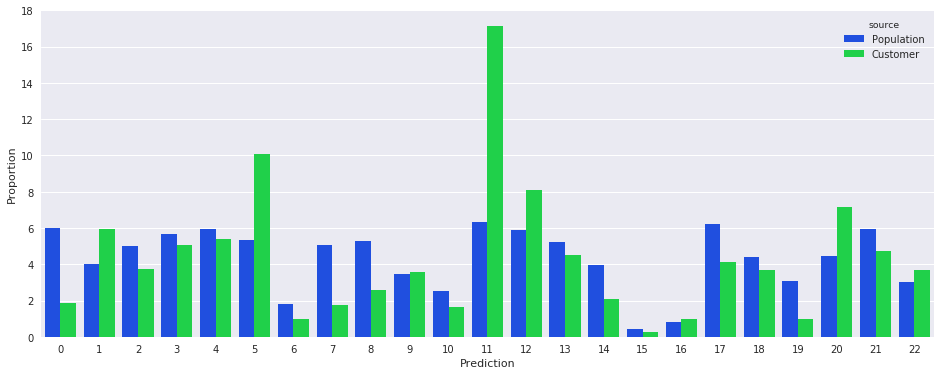

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='prediction', y='proportion', hue='source', data=predictions, palette='bright');
ax.set(xlabel='Prediction', ylabel='Proportion')
plt.show()

<b>Clusters overrepresenting Customer Data:</b> 1, 5, 11, 12, 20 <br>
<b>Clusters underrepresenting Customer Data:</b> 0, 7, 8, 14, 17, 19, 21

In [75]:
cluster_feature = pd.DataFrame(scaler.inverse_transform((pca.inverse_transform(kmeans.cluster_centers_))), columns=df_azdias_clean.columns)
# cluster_feature.reset_index(inplace=True)[index].column = 'CLUSTER'
cluster_feature

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,-1.297646,1.031627,-1.336239,1.079584,-0.900456,0.962517,0.754994,0.667786,-0.467391,-0.019323,...,-0.130349,1.069965,-0.377524,-0.180690,-0.497518,-0.377848,0.467391,0.872829,0.658719,-0.425764
1,0.991090,-0.907319,1.260591,-1.042366,0.897941,-0.733635,-0.878565,-0.503623,-0.524897,-0.707117,...,0.167464,-0.703618,-0.196108,0.066045,1.280044,-0.279881,0.524897,-0.970135,-0.478473,0.322068
2,-1.039270,-1.161841,-0.081825,0.974723,-0.955473,0.751889,1.020064,-0.496719,0.308901,-0.059580,...,0.335285,-0.539321,0.563349,0.023611,0.014914,0.065054,-0.308901,0.982815,-0.535547,0.204908
3,0.956977,0.908672,-0.439785,-0.747864,0.831372,-0.633987,-0.878194,1.167050,-0.453879,-0.453812,...,-0.222386,0.886409,-0.211239,-0.158347,-0.492471,-0.340287,0.453879,-0.892631,0.800866,-0.193664
4,0.620619,0.838870,0.849819,-0.761402,0.586818,-0.528771,-0.367704,-0.537069,1.877345,-0.164399,...,0.405671,-0.733308,-0.344910,0.064975,-0.428962,1.889409,-1.877345,-0.587311,-0.869260,0.550122
5,0.063404,-0.784238,0.981055,-0.354214,0.250575,-0.163893,-0.325554,-0.878263,-0.516973,0.879698,...,0.098215,-0.656595,-0.235231,0.063944,1.277816,-0.297854,0.516973,-0.193734,-0.564535,0.264574
6,-0.848757,-1.128541,-0.072363,0.787632,-0.774054,0.453797,0.778780,-0.441891,0.044236,0.041976,...,0.120982,-0.270708,0.375352,-0.038403,0.065458,-0.110221,-0.044236,0.711840,-0.235786,0.017115
7,-1.082050,-1.183532,-0.894665,1.166332,-1.018280,0.564154,0.825632,0.437986,-0.274520,0.024430,...,-0.218383,0.961306,-0.244266,-0.147851,-0.532876,-0.364988,0.274520,0.951187,0.744092,-0.495726
8,-0.905371,0.873805,-0.820755,0.906040,-0.846827,1.093367,0.915507,0.182092,-0.264799,0.196126,...,-0.476070,-0.178008,0.687724,-0.148411,-0.083506,-0.374077,0.264799,0.829804,-0.367893,0.145245
9,0.453018,-0.896663,-0.103758,-0.334094,0.381171,-0.723744,-0.675109,0.560622,-0.391341,0.220248,...,-0.256671,0.835297,-0.281834,-0.087782,-0.386584,-0.351707,0.391341,-0.406012,0.953323,-0.583017


In [95]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Analysing Cluster 5, 11, 20 as they are the most prominent
for i in [5,11,20]:
    print('CLUSTER {}:'.format(i))
    cfeat = cluster_feature.iloc[i, :].sort_values(ascending=False)
    print('Higher Contributing Attributes:\n{}\n'.format(cfeat[:7]))
    print('Lower Contributing Attributes:\n{}\n\n'.format(cfeat[-7:]))

CLUSTER 5:
Higher Contributing Attributes:
LP_STATUS_GROB_4.0    1.277816
FINANZ_MINIMALIST     0.981055
HEALTH_TYP            0.879698
MOBI_REGIO            0.844427
KBA05_GBZ             0.835534
KBA05_ANTG1           0.771195
VERS_TYP              0.710392
Name: 5, dtype: float64

Lower Contributing Attributes:
PLZ8_ANTG4         -0.702591
SEMIO_KAEM         -0.736944
ANREDE_KZ          -0.784238
PLZ8_ANTG3         -0.815287
EWDICHTE           -0.820108
ORTSGR_KLS9        -0.835245
FINANZ_HAUSBAUER   -0.878263
Name: 5, dtype: float64


CLUSTER 11:
Higher Contributing Attributes:
GREEN_AVANTGARDE      1.937374
LP_STATUS_GROB_5.0    1.880708
FINANZ_MINIMALIST     1.310257
SEMIO_VERT            1.017893
KBA05_ANTG1           0.953922
MOBI_REGIO            0.881643
KBA05_GBZ             0.726200
Name: 11, dtype: float64

Lower Contributing Attributes:
CAMEO_INTL_2015_WEALTH           -0.818347
FINANZ_HAUSBAUER                 -0.835467
SEMIO_KAEM                       -0.864567
ANREDE_K

In [96]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Analysing Cluster 0, 7, 8 as they are the most prominent
for i in [0,7,8]:
    print('CLUSTER {}:'.format(i))
    cfeat = cluster_feature.iloc[i, :].sort_values(ascending=False)
    print('Higher Contributing Attributes:\n{}\n'.format(cfeat[:7]))
    print('Lower Contributing Attributes:\n{}\n\n'.format(cfeat[-7:]))

CLUSTER 0:
Higher Contributing Attributes:
SEMIO_RAT             1.606114
SEMIO_TRADV           1.289052
SEMIO_PFLICHT         1.271994
FINANZ_SPARER         1.079584
LP_STATUS_GROB_1.0    1.069965
ANREDE_KZ             1.031627
SEMIO_KAEM            1.013750
Name: 0, dtype: float64

Lower Contributing Attributes:
NATIONALITAET_KZ_1.0   -0.651750
RETOURTYP_BK_S         -0.672063
FINANZ_VORSORGER       -0.900456
SEMIO_LUST             -0.913282
SEMIO_VERT             -1.086786
ALTERSKATEGORIE_GROB   -1.297646
FINANZ_MINIMALIST      -1.336239
Name: 0, dtype: float64


CLUSTER 7:
Higher Contributing Attributes:
SEMIO_KULT            1.548189
SEMIO_FAM             1.532242
SEMIO_REL             1.440198
SEMIO_SOZ             1.277447
FINANZ_SPARER         1.166332
LP_STATUS_GROB_1.0    0.961306
SEMIO_VERT            0.954698
Name: 7, dtype: float64

Lower Contributing Attributes:
FINANZ_VORSORGER       -1.018280
SEMIO_DOM              -1.079286
ALTERSKATEGORIE_GROB   -1.082050
SEMIO_KAEM  

### Discussion 3.3: Compare Customer Data to Demographics Data

#### Overrepresented Clusters: 5, 11, 20

**Cluster 5** seems to represent aged and affluent `Home Owners` and weighs them on their health, movement and insurance type. They seem to own a 1-2 family house in a locality which is sparsely populated therefore, features related to 6+ family homes, density of household and community size has been negated.

**Cluster 11** seems to represent independent `Young Working Females` who are ambitious and are amongst top earners of the society. They seem to be putting up in an apartments or 1-2 family houses. They are outgoing in nature and probably lacking time to have financial interests. It also weighs their membership in environmental sustainability as a part of youth. It correctly negates gender, combative attitude and other wealth related attributes.

**Cluster 20** seems to represent `Females in early 20s or late teens` who either are still studying or have just started earning. They seem to be full of dreams and sensuality however they are less affluent and often putting up in a 6-10 family house. It weighs the kind of shopper they are as traits of a money-saver and a rational-thinker are not expected out of them. It correctly negates out those parameters along with the gender attribute.

#### Underrepresented Clusters: 0, 7, 8

**Cluster 0** seems to represent aged and retired `Veterans` who are now a low-income earners thus money-savers. They usually display rational, dutiful, tradional-minded and/or combative personality traits. It correctly negates out the Nationality attribute along with traits of being dreamful and sensual as their lives have been as real as it can be.

**Cluster 7** seems to represent `Housewives` from low-income households who do not earn yet are efficient money-savers. They are usually flexible, dreamful, cultural-minded, family-minded, religious and or socially-minded. It correctly negates out harsh traits of being dominant-minded, critical-minded or having combative attitude. 

**Cluster 8** seems to represent middle aged salaried `Family Man` who is rational, dutiful and tradional-minded. They are money saver in several context however they also believe in investing a portion of saving to gain some extra income in things like Stocks and Mutual Funds. They seem to belong to comfortable or prosperous household therefore it correctly negates out attributes related to low-income households  

#### Conclusion

It is observed that the company should target `Young Females` (between 18 - 30) as well as aged and affluent `Home Owners`. It is also noted that people with money-saving mindset like `Veterans`, `Housewives` and `Family Man` are less likely to become potential customers.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.